Установка и импортирование бибилиотек, загрузка датасета Rotten Tomatoes Reviews (freshness, reviews)

In [2]:
!pip install tensorflow

In [3]:
import re
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

In [6]:
data = pd.read_csv('rt_reviews.csv', encoding='latin-1', quotechar='"', escapechar='\\', on_bad_lines='skip')
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96275 entries, 0 to 96274
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Freshness  96275 non-null  object
 1   Review     96275 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


,Freshness,Review
0,fresh,"Manakamana doesn't answer any questions, yet ..."
1,fresh,Wilfully offensive and powered by a chest-thu...
2,rotten,It would be difficult to imagine material mor...
3,rotten,Despite the gusto its star brings to the role...
4,rotten,If there was a good idea at the core of this ...
5,rotten,"Gleeson goes the Hallmark Channel route, dama..."
6,fresh,It was the height of satire in 1976: dark as ...
7,rotten,"Everyone in ""The Comedian"" deserves a better ..."
8,rotten,Actor encourages grumpy Christians to embrace...
9,fresh,"Slight, contained, but ineffably soulful."


In [7]:
with open('stopwords.txt', 'r') as sw:
  sw = sw.read()

Препроцессинг: чистка, токенизация, векторизация, паддинг и разделение датасета

In [8]:
def cleaning(text, sw=sw):
  text = text.lower()
  text = re.sub(r'[^a-z\s]', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  text = [word for word in text.split() if word not in sw]
  return ' '.join(text)


data['Review'] = data['Review'].apply(cleaning)
data['Review'].head(10)

,Review
0,manakamana doesnt answer questions yet makes p...
1,wilfully offensive powered chestthumping machi...
2,difficult imagine material wrong spade lost found
3,despite gusto star brings role hard ride shotg...
4,good idea core film buried unsightly pile flat...
5,gleeson goes hallmark channel route damaging i...
6,height satire dark hell patently absurd surely...
7,everyone comedian deserves better movie comedian
8,actor encourages grumpy christians embrace season
9,slight contained ineffably soulful


In [9]:
# деление на тексты и метки
text = data['Review'].values
labels = data['Freshness'].map({'fresh': 1, 'rotten': 0}).values

# настройка TextVectorization
max_tokens = 10000 # макс. размер словаря
output_sequence_length = 100 # макс. длина последовательности
vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_sequence_length
)

# обучение векторизатор на обучающих текстах
vectorizer.adapt(text)

# преобразование текстовых данных в числовые
vectorized_text = vectorizer(text).numpy()

print(vectorized_text[1])

[   1 1393 8058    1 8441   11 3025   42    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [10]:
# разделение на обучающую, проверочную и тестовую выборки
x_train, x_temp, y_train, y_temp = train_test_split(vectorized_text, labels, test_size=0.3, random_state=42)

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print("Обучающая:", x_train.shape, y_train.shape)
print("Проверочная:", x_val.shape, y_val.shape)
print("Тестовая:", x_test.shape, y_test.shape)

Обучающая: (67392, 100) (67392,)
Проверочная: (14441, 100) (14441,)
Тестовая: (14442, 100) (14442,)


Модель CNN

In [11]:
# параметры
embedding_dim = 128 # размерность эмбеддингов
sequence_length = 100 # длина последовательности после векторизации
kernel_size = 6 # размер ядра свёртки
num_classes = 1 # для бинарной классификации (0/1)

# создание модели
model = Sequential([
    # эмбеддинг слой
    Embedding(input_dim=max_tokens, output_dim=embedding_dim),
    # первый сверточный слой
    Conv1D(filters=128, kernel_size=kernel_size, activation='relu'),
    # второй сверточный слой
    Conv1D(filters=64, kernel_size=kernel_size, activation='relu'),
    # глобальный пулинг
    GlobalMaxPooling1D(),
    # полносвязный слой
    Dense(64, activation='relu'),
    Dropout(0.5),
    # выходной слой
    Dense(num_classes, activation='sigmoid')  # для бинарной классификации
])

# компиляция модели
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Обучение модели

In [12]:
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 186s 87ms/step - accuracy: 0.6608 - loss: 0.5936 - val_accuracy: 0.7773 - val_loss: 0.4716
Epoch 2/5
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 197s 85ms/step - accuracy: 0.8273 - loss: 0.3909 - val_accuracy: 0.7819 - val_loss: 0.4604
Epoch 3/5
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 204s 86ms/step - accuracy: 0.8972 - loss: 0.2520 - val_accuracy: 0.7666 - val_loss: 0.5632
Epoch 4/5
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 202s 86ms/step - accuracy: 0.9523 - loss: 0.1287 - val_accuracy: 0.7704 - val_loss: 0.7931
Epoch 5/5
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 201s 86ms/step - accuracy: 0.9753 - loss: 0.0676 - val_accuracy: 0.7628 - val_loss: 1.2238


Оценка модели

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

2250/2250 - 46s - 21ms/step - accuracy: 0.8499 - loss: 0.4884
Test accuracy: 0.8499


In [13]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

452/452 - 8s - 19ms/step - accuracy: 0.7628 - loss: 1.2238
Test accuracy: 0.7628


Дисклеймер:

У меня пропал интеренет во время загрузки блокноту, поэтому мне пришлось заново все перезагрузить. В первый раз во время обучения модели в каждой эпохе было по 10500, а во второй раз - по 2106.

Сохранилась оценка модели с первого обучения, и я скопировала этот код, чтобы снова прокрутить данные со второго обучения. Результаты изменились, accuracy упал.

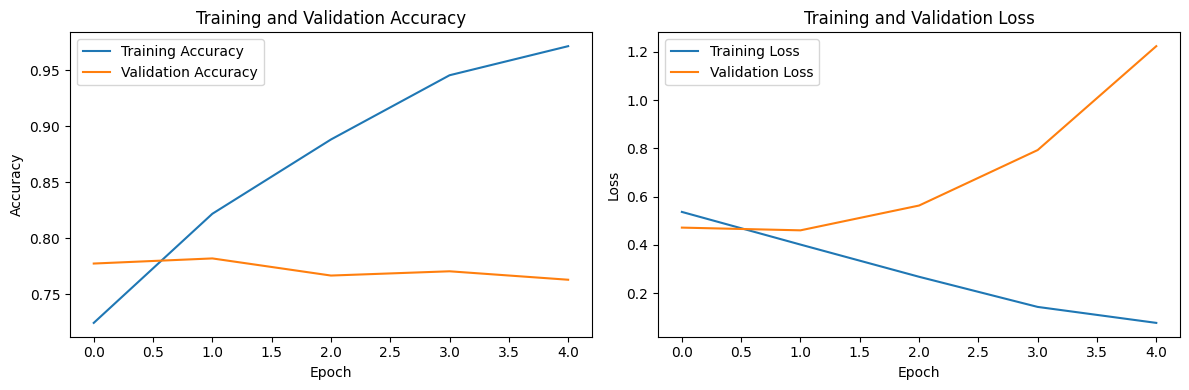

In [14]:
# отрисовка графика прогресса обучения
plt.figure(figsize=(12, 4))

# отрисовка аккуратности (точности) модели
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# отрисовка значений функции потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

# предсказания модели
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # порог 0.5 для бинарной классификации

# вычисление метрики
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")


452/452 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step
Precision: 0.7571
Recall:    0.7703
F1-score:  0.7637


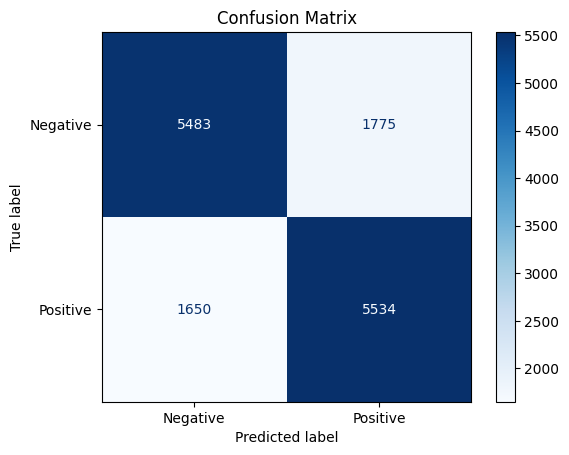

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# матрица ошибок
cm = confusion_matrix(y_test, y_pred)

# визуализация
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Поменяем параметры и обучим снова.

In [17]:
embedding_dim = 256 # увеличила размерность эмбеддинга
sequence_length = 150 # увеличила длину последовательности
kernel_size = 4 # уменьшила размер ядра свёртки
num_classes = 1

model = Sequential([
    Embedding(input_dim=max_tokens, output_dim=embedding_dim),
    Conv1D(filters=128, kernel_size=kernel_size, activation='relu'),
    Conv1D(filters=64, kernel_size=kernel_size, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test)) # уменьшила кол-во эпох

Epoch 1/3
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 267s 126ms/step - accuracy: 0.6705 - loss: 0.5860 - val_accuracy: 0.7768 - val_loss: 0.4677
Epoch 2/3
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 302s 116ms/step - accuracy: 0.8273 - loss: 0.3955 - val_accuracy: 0.7809 - val_loss: 0.4686
Epoch 3/3
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 270s 120ms/step - accuracy: 0.8924 - loss: 0.2631 - val_accuracy: 0.7691 - val_loss: 0.5587


In [18]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

452/452 - 11s - 23ms/step - accuracy: 0.7691 - loss: 0.5587
Test accuracy: 0.7691


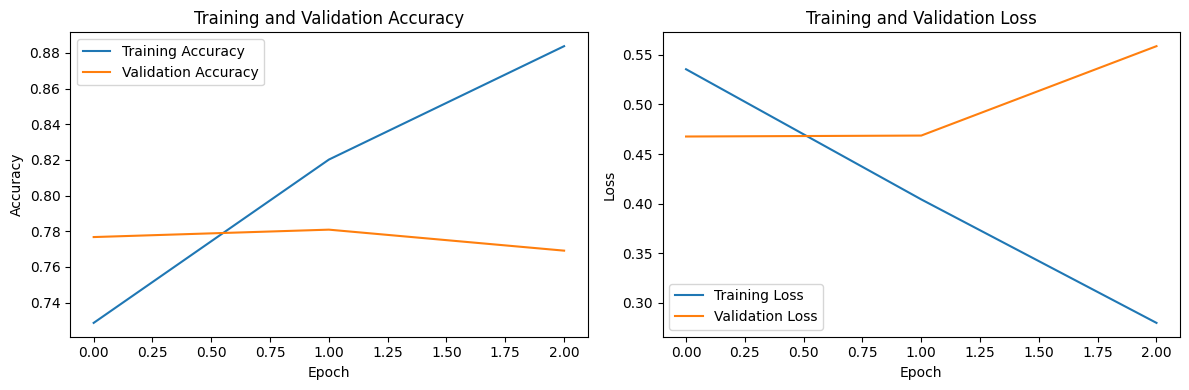

In [19]:
plt.figure(figsize=(12, 4))

# отрисовка аккуратности (точности) модели
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# отрисовка значений функции потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

452/452 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step
Precision: 0.7450
Recall:    0.8147
F1-score:  0.7783


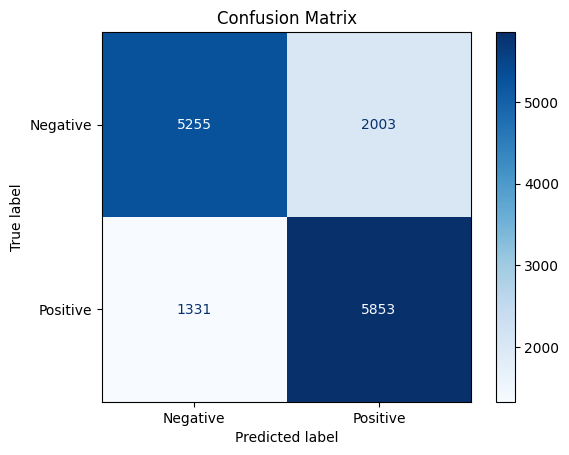

In [21]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Результат обучения немного повысился.

Precision снизился, но Recall и F-1 повысились.

In [22]:
model.save('CNN_1.keras')